In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[list[HumanMessage | AIMessage], "The messages in the conversation"]
  city : str
  interests : list[str]
  itinerary : str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [ ]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please Enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please Enter your interest for the trip to : {state['city']} (comma-seperated): ")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }
def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])} ")
    response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
    print("\nFinal Itinearary: ")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

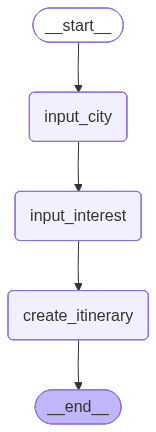

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [ ]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please Enter the city you want to visit for your day trip: 
Your Input: Mumbai
Please Enter your interest for the trip to : Mumbai (comma-seperated): 
Your Input: Gateway of india,taj hotel
Creating an itinerary for Mumbai based on interests : Gateway of india, taj hotel 

Final Itinearary: 
Here's a brief, bulleted itinerary for your day trip to Mumbai based on your interests:

* 9:00 AM: Start the day with a visit to the iconic **Gateway of India**, a historic monument and a symbol of the city.
* 10:30 AM: Take a stroll along the **Marine Drive**, which offers breathtaking views of the Arabian Sea.
* 12:00 PM: Visit the luxurious **Taj Mahal Palace Hotel** for lunch and explore its stunning architecture and beautiful interiors.
* 2:30 PM: Take a short walk to the nearby **Colaba Causeway**, a popular shopping street filled with street food, cafes, and souvenir shops.
* 4:30 PM: End the day with a **Sunset View** at the Gateway of India, wat

In [ ]:
!pip install gradio

In [ ]:
!pip uninstall -y gradio gradio_client

Found existing installation: gradio 5.50.0
Uninstalling gradio-5.50.0:
  Successfully uninstalled gradio-5.50.0
Found existing installation: gradio_client 1.14.0
Uninstalling gradio_client-1.14.0:
  Successfully uninstalled gradio_client-1.14.0


In [ ]:
!pip install -U gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.2/315.2 kB 23.2 MB/s eta 0:00:00


In [ ]:
# If needed, install dependencies (run once in a new cell):
# !pip install -U gradio langchain langchain_groq

import os
import gradio as gr
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

# ---------- State definition ----------
class PlannerState(TypedDict):
    messages: Annotated[list[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: list[str]
    itinerary: str

# ---------- LLM setup ----------
# Prefer using an environment variable in real use:
# %env GROQ_API_KEY=your_key_here
llm = ChatGroq(
    temperature=0,
    groq_api_key=os.environ.get("GROQ_API_KEY", "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"),
    model_name="llama-3.3-70b-versatile",
)

# ---------- Prompt ----------
itinerary_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful travel assistant. Create a day trip itinerary for {city} "
        "based on the user's interests: {interests}. Provide a brief, bulleted itinerary."
    ),
    ("human", "Create an itinerary for my day trip."),
])

# ---------- Core itinerary creation logic ----------
def create_itinerary(city: str, interests: str) -> str:
    state: PlannerState = {
        "messages": [],
        "city": city,
        "interests": [i.strip() for i in interests.split(",") if i.strip()],
        "itinerary": "",
    }

    state["messages"].append(HumanMessage(content=f"City: {city}"))
    state["messages"].append(HumanMessage(content=f"Interests: {interests}"))

    messages = itinerary_prompt.format_messages(
        city=state["city"],
        interests=", ".join(state["interests"])
    )

    response = llm.invoke(messages)
    itinerary_text = response.content

    state["messages"].append(AIMessage(content=itinerary_text))
    state["itinerary"] = itinerary_text

    return itinerary_text

# ---------- Function that Gradio calls ----------
def travel_planner(city: str, interests: str) -> str:
    if not city.strip():
        return "Please enter a city."
    if not interests.strip():
        return "Please enter at least one interest (comma-separated)."
    return create_itinerary(city, interests)

# ---------- Gradio Interface (NO theme arg) ----------
interface = gr.Interface(
    fn=travel_planner,
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3a51e780fde0193778.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
